In [2]:
# Import necessary libraries

import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import pandas_datareader.data as web
import yfinance as yf
style.use('ggplot')

In [3]:
#Need to provide a start date and end date for which the stock data has to be retreived for Tesla from yahoo finance api

start = dt.datetime(2000,1,1)
end = dt.datetime(2022,12,31)

stock_symbol = 'TSLA'

# Download stock data from Yahoo Finance

df = yf.download(stock_symbol, start=start, end=end)
df.to_csv('Tesla.csv')


[*********************100%%**********************]  1 of 1 completed


                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2010-06-29  1.266667  1.666667  1.169333  1.592667   1.592667  281494500
2010-06-30  1.719333  2.028000  1.553333  1.588667   1.588667  257806500
2010-07-01  1.666667  1.728000  1.351333  1.464000   1.464000  123282000
2010-07-02  1.533333  1.540000  1.247333  1.280000   1.280000   77097000
2010-07-06  1.333333  1.333333  1.055333  1.074000   1.074000  103003500


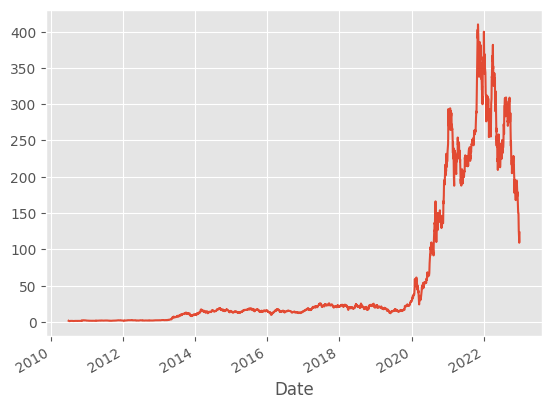

In [5]:
# Tesla closing prices plotted
df = pd.read_csv('Tesla.csv',parse_dates=True,index_col=0)
print(df.head())

df['Adj Close'].plot()
plt.show()

In [6]:
#Since there are too many datapoints,we will resample the data for 10 days i.e convert 10 day data into 1 point to make
#it easier for us to understand the data
#df_ohlc - ohlc stands for Open High Low Close.In Financial Markets,the stock prices are generally represented with
#the help of candlestick charts,the candlestick chart represent Open,High Low and Close
#we use the resample.ohlc method inbuilt in pandas to convert the data into 10 day data
#For Volume in place of taking the ohlc or mean,we take the sum over 10 days

df['100ma'] = df['Adj Close'].rolling(window=100).mean()
print(df.head())
print(df.tail())

                Open      High       Low     Close  Adj Close     Volume  \
Date                                                                       
2010-06-29  1.266667  1.666667  1.169333  1.592667   1.592667  281494500   
2010-06-30  1.719333  2.028000  1.553333  1.588667   1.588667  257806500   
2010-07-01  1.666667  1.728000  1.351333  1.464000   1.464000  123282000   
2010-07-02  1.533333  1.540000  1.247333  1.280000   1.280000   77097000   
2010-07-06  1.333333  1.333333  1.055333  1.074000   1.074000  103003500   

            100ma  
Date               
2010-06-29    NaN  
2010-06-30    NaN  
2010-07-01    NaN  
2010-07-02    NaN  
2010-07-06    NaN  
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-12-23  126.370003  128.619995  121.019997  123.150002  123.150002   
2022-12-27  117.500000  119.669998  108.760002  109.099998  109.099998   
2022-12-28  110.349998  116.269

In [7]:
#Candlestick representation:
df_ohlc = df['Adj Close'].resample('10D').ohlc()
df_volume = df['Volume'].resample('10D').sum()
df_ohlc.reset_index(inplace=True)
df_ohlc['Date'] = df_ohlc['Date'].map(mdates.date2num)
print(df_ohlc.head())

      Date      open      high       low     close
0  14789.0  1.592667  1.592667  1.053333  1.164000
1  14799.0  1.160000  1.376000  1.136667  1.376000
2  14809.0  1.460667  1.460667  1.348000  1.381333
3  14819.0  1.356667  1.463333  1.306000  1.306000
4  14829.0  1.306667  1.306667  1.173333  1.276667


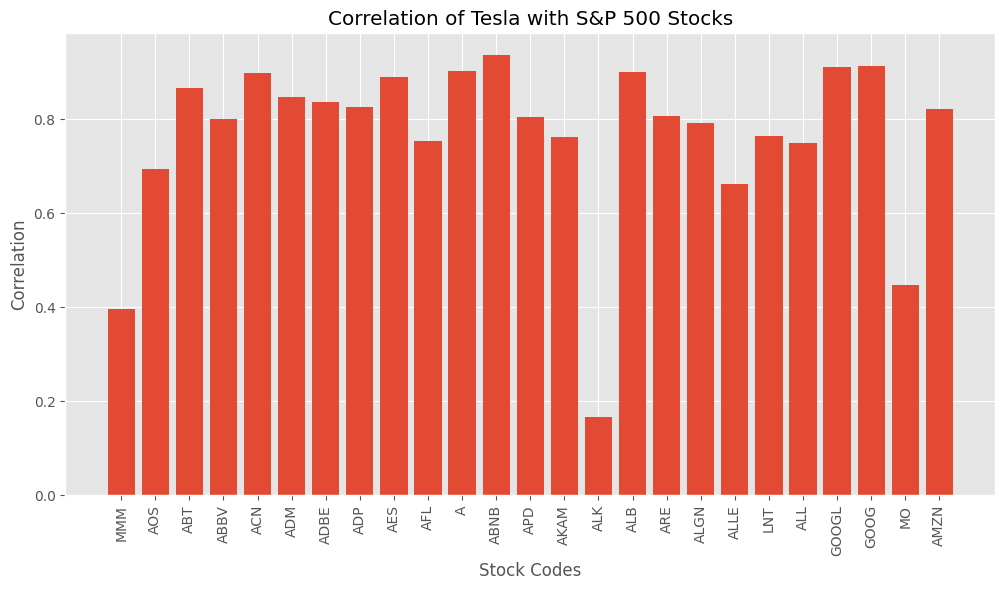

In [24]:
#Tesla correlation with 25 other companies
def tesla_corr_heatmap():
    df2 = pd.read_csv('./Tesla_data/S&P500_joined_closes.csv').fillna(value = 0)
    df1 = pd.read_csv('Tesla.csv').fillna(value = 0)
    
    # for column in df2:
    #     print(df2[column])
    corr_arr = []
    tickers = []
    for column in df2.columns[1:]:
        corr_arr.append(df1["Adj Close"].corr(df2[column]))
        tickers.append(column)


    plt.figure(figsize=(12, 6)) 
    plt.bar(tickers,corr_arr)
    plt.xlabel('Stock Codes')
    plt.ylabel('Correlation')
    plt.title('Correlation of Tesla with S&P 500 Stocks')
    plt.xticks(rotation=90)
    plt.show()



tesla_corr_heatmap()

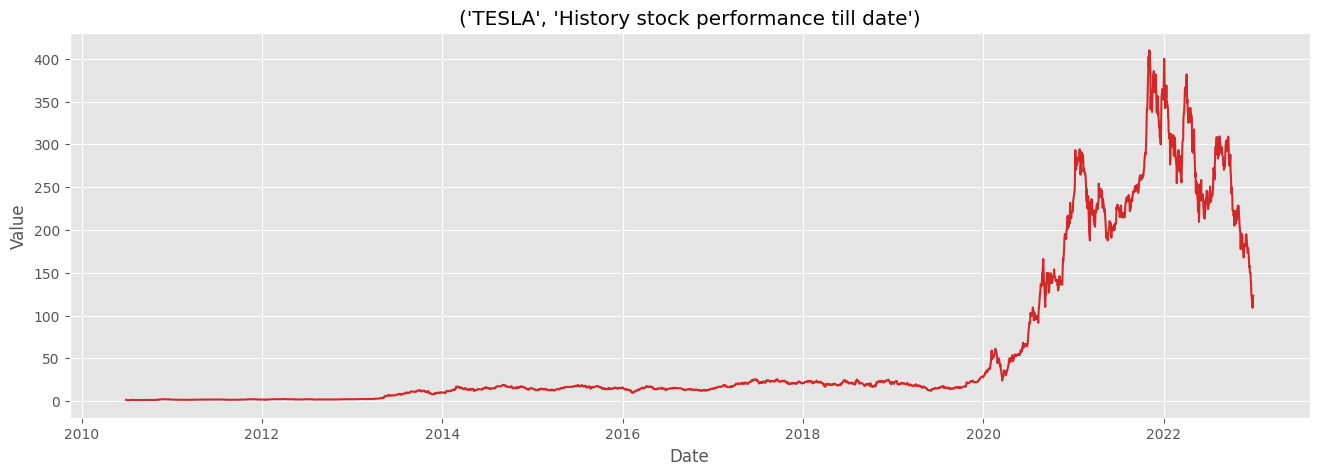

In [25]:
#Visualising part is complete

#Now analyze the results of all the data that we have

#We can start with predicting the stock prices with linear regression

x = df.index
y = df['Adj Close']

def df_plot(data, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()


stock_name= "TESLA"
title = (stock_name,"History stock performance till date")

df_plot(df , x , y , title=title,xlabel='Date', ylabel='Value',dpi=100)


In [26]:
#Gives a summary of the dataset

print(df.describe())
print(len(df))

              Open         High          Low        Close    Adj Close  \
count  3150.000000  3150.000000  3150.000000  3150.000000  3150.000000   
mean     58.860577    60.176703    57.402961    58.807496    58.807496   
std      95.658595    97.854579    93.175266    95.526397    95.526397   
min       1.076000     1.108667     0.998667     1.053333     1.053333   
25%       8.976167     9.117500     8.765667     8.957666     8.957666   
50%      16.229000    16.491000    15.945000    16.222334    16.222334   
75%      24.622500    25.086666    24.158668    24.448000    24.448000   
max     411.470001   414.496674   405.666656   409.970001   409.970001   

             Volume        100ma  
count  3.150000e+03  3051.000000  
mean   9.359654e+07    57.524872  
std    8.169856e+07    93.434799  
min    1.777500e+06     1.399193  
25%    4.234658e+07    10.279910  
50%    7.596600e+07    15.982487  
75%    1.172978e+08    23.105607  
max    9.140820e+08   330.935132  
3150


In [27]:
#'Adj Close' is the target variable for regression

x = df[['Open', 'High','Low', 'Volume']]
y = df['Adj Close']


# Linear regression Model for stock prediction 
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.15 , shuffle=False,random_state = 0)
print(train_x.shape )
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)



regression = LinearRegression()
regression.fit(train_x, train_y)
print("regression coefficient",regression.coef_)
print("regression intercept",regression.intercept_)

#Here we will compute the coefficient of determination denoted by R², which takes values between 0 and 1, the higher the value R² the more successful the linear regression is at explaining the variation of Y values, in our case the Y values represent the close stock prices of the subjected company. The below is the math behind The coefficient of determination R²

# the coefficient of determination R² 
regression_confidence = regression.score(test_x, test_y)
print("linear regression confidence: ", regression_confidence)


predicted=regression.predict(test_x)
print(test_x.head())

print(predicted.shape)


dfr=pd.DataFrame({'Actual_Price':test_y, 'Predicted_Price':predicted})
#Adding actual dates to the newly created dataframe to make it easier to understand
print(dfr.head())
num_data_points = len(dfr)
print(num_data_points)
start_date = '2021-01-29'  # Replace with your desired start date
date_range = pd.date_range(start=start_date, periods=num_data_points)
dfr['Date'] = date_range


print(dfr.head(10))
print(dfr.describe())
dfr.to_csv('ActualvPredicted_prices.csv')

(2677, 4)
(473, 4)
(2677,)
(473,)
regression coefficient [-5.67354705e-01  9.45177520e-01  6.18120076e-01 -7.19608817e-10]
regression intercept 0.039399478591409576
linear regression confidence:  0.9949992091767349
                  Open        High         Low     Volume
Date                                                     
2021-02-17  259.696655  266.613342  254.003326   77989500
2021-02-18  260.299988  264.896667  258.756653   53871300
2021-02-19  265.000000  265.596680  259.123322   56874900
2021-02-22  254.213333  256.166656  236.733337  111809100
2021-02-23  220.710007  237.869995  206.333328  199820700
(473,)
            Actual_Price  Predicted_Price
Date                                     
2021-02-17    266.049988       261.644651
2021-02-18    262.459991       262.635267
2021-02-19    260.433319       260.854813
2021-02-22    238.166672       244.182403
2021-02-23    232.946671       227.042890
473
            Actual_Price  Predicted_Price       Date
Date                 

In [28]:
#Accuracy of the model
x2 = dfr.Actual_Price.mean()
y2 = dfr.Predicted_Price.mean()
Accuracy1 = x2/y2*100
print("The accuracy of the model is " , Accuracy1)

The accuracy of the model is  99.67054996048016


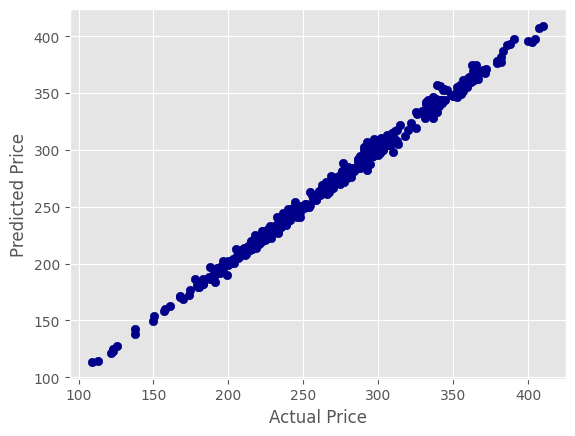

In [29]:
#Scatterplot
plt.scatter(dfr.Actual_Price, dfr.Predicted_Price,  color='Darkblue')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.show()


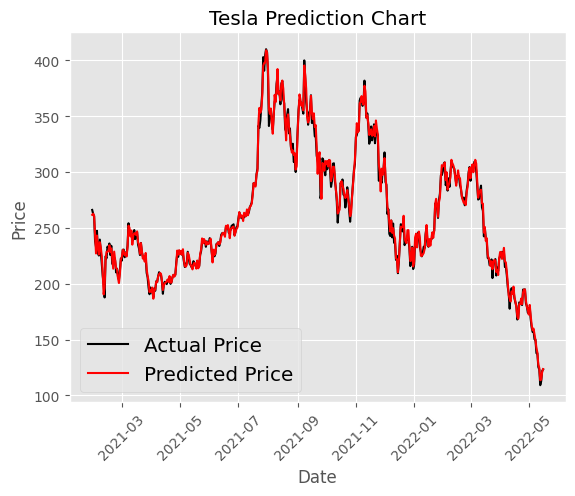

Mean Squared Error: 16.37432736513001
R-squared: 0.9949992091767349


In [30]:
#Prediction Chart- Tesla
x = dfr['Date']
y_actual = dfr['Actual_Price']
y_predicted = dfr['Predicted_Price']
plt.plot(x, y_actual, color='black', label='Actual Price')
plt.plot(x, y_predicted, color='red', label='Predicted Price')
plt.title("Tesla Prediction Chart")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(fontsize="x-large")
plt.xticks(rotation=45)
plt.show()

mse = mean_squared_error(test_y, predicted)
print(f'Mean Squared Error: {mse}')

# R-squared
r2 = r2_score(test_y, predicted)
print(f'R-squared: {r2}')

In [39]:
df2 = pd.read_csv('./Tesla_data/S&P500_joined_closes.csv').fillna(value = 0)
df2.drop(columns='MMM', inplace=True)
df2.drop(columns='ALK', inplace=True)
df2.drop(columns='MO', inplace=True)

In [40]:
df1.index = df1.index.strftime('%Y-%m-%d %H:%M:%S')

In [41]:
print(df1.index.dtype)

object


In [42]:
print(df2.index.dtype)

int64


In [43]:
print(df2.index.dtype)

int64


In [44]:
df2.set_index('Date', inplace=True)

df2.index = pd.to_datetime(df2.index, format='%d-%m-%Y')

In [45]:
df1 = df.drop(columns=['Open','High','Low','Close','Volume','100ma'])

merged_df = pd.merge(df1, df2, on='Date', how='inner')

In [46]:
print(merged_df.head())


            Adj Close       AOS        ABT  ABBV        ACN        ADM  \
Date                                                                     
2010-06-30   1.588667  6.571832  16.698841   0.0  30.078590  18.360682   
2010-07-01   1.464000  6.569104  16.584608   0.0  29.790638  18.318018   
2010-07-02   1.280000  6.605925  16.584608   0.0  29.526041  18.133129   
2010-07-06   1.074000  6.570469  16.666714   0.0  29.891811  18.332237   
2010-07-07   1.053333  6.910039  17.030821   0.0  30.553301  18.730453   

                 ADBE        ADP       AES        AFL  ...       AKAM  \
Date                                                   ...              
2010-06-30  26.430000  25.833788  6.594038  15.375381  ...  40.570000   
2010-07-01  26.660000  25.480858  6.486991  15.605991  ...  40.349998   
2010-07-02  26.730000  25.301195  6.508402  15.537524  ...  39.570000   
2010-07-06  26.340000  25.288370  6.351400  15.696073  ...  40.259998   
2010-07-07  26.790001  25.801701  7.036496 

In [47]:
y = merged_df['Adj Close']

In [48]:
x = merged_df.drop(columns=['Adj Close'])

In [49]:
print(y.head())

Date
2010-06-30    1.588667
2010-07-01    1.464000
2010-07-02    1.280000
2010-07-06    1.074000
2010-07-07    1.053333
Name: Adj Close, dtype: float64


In [50]:
print(x.head())

                 AOS        ABT  ABBV        ACN        ADM       ADBE  \
Date                                                                     
2010-06-30  6.571832  16.698841   0.0  30.078590  18.360682  26.430000   
2010-07-01  6.569104  16.584608   0.0  29.790638  18.318018  26.660000   
2010-07-02  6.605925  16.584608   0.0  29.526041  18.133129  26.730000   
2010-07-06  6.570469  16.666714   0.0  29.891811  18.332237  26.340000   
2010-07-07  6.910039  17.030821   0.0  30.553301  18.730453  26.790001   

                  ADP       AES        AFL          A  ...       AKAM  \
Date                                                   ...              
2010-06-30  25.833788  6.594038  15.375381  18.337805  ...  40.570000   
2010-07-01  25.480858  6.486991  15.605991  18.241058  ...  40.349998   
2010-07-02  25.301195  6.508402  15.537524  17.924999  ...  39.570000   
2010-07-06  25.288370  6.351400  15.696073  17.899206  ...  40.259998   
2010-07-07  25.801701  7.036496  16.384310 

In [51]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.15 , shuffle=False,random_state = 0)
print(train_x.shape )
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(2676, 22)
(473, 22)
(2676,)
(473,)


In [52]:
regression = LinearRegression()
regression.fit(train_x, train_y)
print("regression coefficient",regression.coef_)
print("regression intercept",regression.intercept_)

#Here we will compute the coefficient of determination denoted by R², which takes values between 0 and 1, the higher the value R² the more successful the linear regression is at explaining the variation of Y values, in our case the Y values represent the close stock prices of the subjected company. The below is the math behind The coefficient of determination R²

# the coefficient of determination R² 
regression_confidence = regression.score(test_x, test_y)
print("linear regression confidence: ", regression_confidence)


predicted=regression.predict(test_x)


print(predicted.shape)

regression coefficient [ 0.01055737  0.51108214 -0.07814451  0.16190016  0.3841718   0.04467234
 -0.4938835   2.06084842 -1.58451015 -0.04103807  0.57566079  0.43717528
  0.19012504  0.44786101 -0.44457301  0.02501888 -0.009715   -0.02426487
 -0.46976193  1.96765701 -1.06601184 -0.09858832]
regression intercept -29.807114426861165
linear regression confidence:  0.24137438804277944
(473,)


In [53]:
dfr=pd.DataFrame({'Actual_Price':test_y, 'Predicted_Price':predicted})

print(dfr.describe())

       Actual_Price  Predicted_Price
count    473.000000       473.000000
mean     260.542446       251.806240
std       57.282500        43.802168
min      109.099998       167.648080
25%      221.903336       215.959794
50%      246.283340       247.792089
75%      300.029999       281.100647
max      409.970001       369.240944


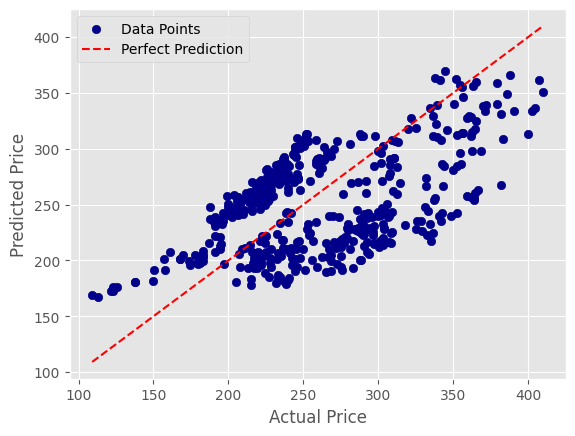

In [54]:
# Scatterplot
plt.scatter(dfr.Actual_Price, dfr.Predicted_Price, color='Darkblue', label='Data Points')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")

# Plotting the line of perfect prediction
plt.plot([dfr.Actual_Price.min(), dfr.Actual_Price.max()], [dfr.Actual_Price.min(), dfr.Actual_Price.max()], color='red', linestyle='--', label='Perfect Prediction')

plt.legend()
plt.show()

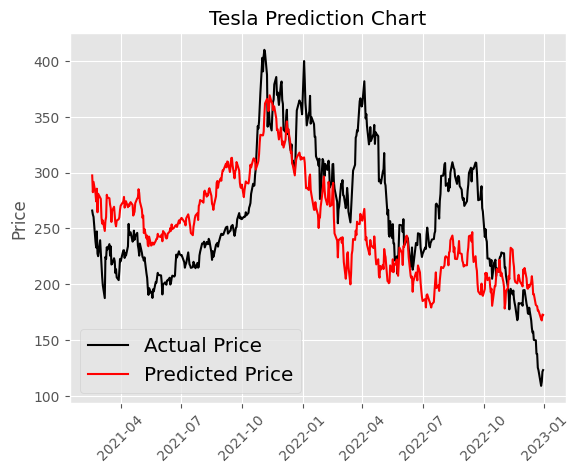

Mean Squared Error: 2484.0039419303694
R-squared: 0.24137438804277944


In [55]:
#Prediction Chart- Tesla

y_actual = dfr['Actual_Price']
y_predicted = dfr['Predicted_Price']
plt.plot(y_actual, color='black', label='Actual Price')
plt.plot(y_predicted, color='red', label='Predicted Price')
plt.title("Tesla Prediction Chart")
plt.ylabel("Price")
plt.legend(fontsize="x-large")
plt.xticks(rotation=45)
plt.show()

mse = mean_squared_error(test_y, predicted)
print(f'Mean Squared Error: {mse}')

# R-squared
r2 = r2_score(test_y, predicted)
print(f'R-squared: {r2}')

C:\Users\abc\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


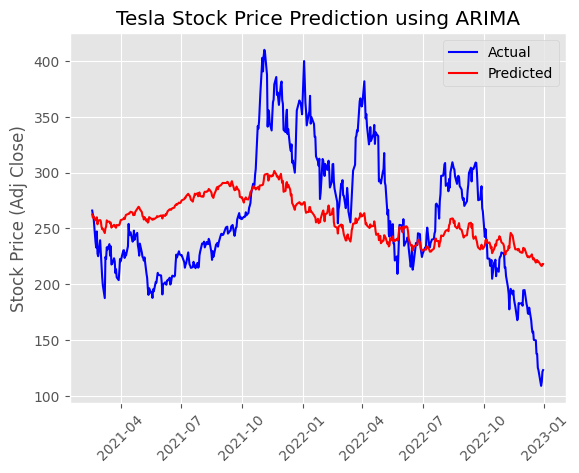

Mean Squared Error: 2636.4621068341835
R-squared: 0.1948130011239848


In [62]:
from statsmodels.tsa.arima.model import ARIMA

# Reset index for model fitting and forecasting
train_y = train_y.reset_index(drop=True)
test_y = test_y.reset_index(drop=True)
train_x = train_x.reset_index(drop=True)
test_x = test_x.reset_index(drop=True)

# Fit ARIMA model
order = (5, 1, 0)  # Specify ARIMA order
model = ARIMA(train_y, exog=train_x, order=order)
fitted_model = model.fit()

# Forecast using the ARIMA model
forecast = fitted_model.forecast(steps=len(test_y), exog=test_x)

# Visualize results with the original date index
plt.plot(dfr.index[-len(test_y):], test_y, color='blue', label='Actual')
plt.plot(dfr.index[-len(test_y):], forecast, color='red', label='Predicted')
plt.title('Tesla Stock Price Prediction using ARIMA')
plt.ylabel('Stock Price (Adj Close)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Evaluate the model
mse = mean_squared_error(test_y, forecast)
print(f'Mean Squared Error: {mse}')

r2 = r2_score(test_y, forecast)
print(f'R-squared: {r2}')


In [104]:
print(forecast)

2676    262.757199
2677    259.327220
2678    261.096350
2679    258.037237
2680    258.370495
           ...    
3144    235.280527
3145    231.714194
3146    231.241933
3147    233.066120
3148    232.873374
Name: predicted_mean, Length: 473, dtype: float64


In [57]:
forecast_array = forecast.values


In [58]:
dfr2 =pd.DataFrame({'Actual_Price':test_y, 'Predicted_Price':forecast_array})

print(dfr2.describe())

       Actual_Price  Predicted_Price
count    473.000000       473.000000
mean     260.542446       257.980927
std       57.282500        20.100537
min      109.099998       216.400821
25%      221.903336       240.886887
50%      246.283340       257.047541
75%      300.029999       273.368919
max      409.970001       301.508572


In [59]:
print(dfr2.head)

<bound method NDFrame.head of      Actual_Price  Predicted_Price
0      266.049988       262.485210
1      262.459991       259.699932
2      260.433319       260.845514
3      238.166672       257.278531
4      232.946671       257.773360
..            ...              ...
468    123.150002       220.414753
469    109.099998       216.799357
470    112.709999       216.400821
471    121.820000       218.242345
472    123.180000       218.139315

[473 rows x 2 columns]>


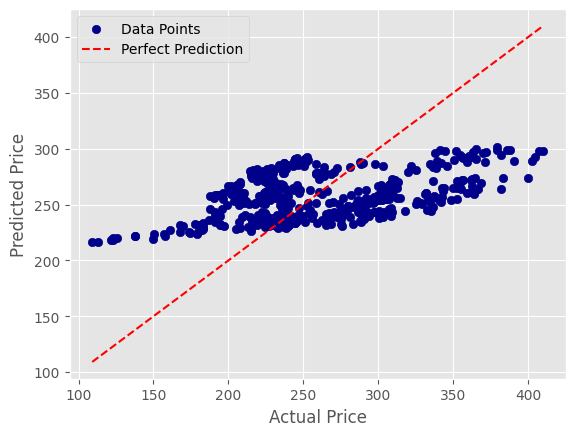

In [60]:
# Scatterplot
plt.scatter(dfr2.Actual_Price, dfr2.Predicted_Price, color='Darkblue', label='Data Points')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")

# Plotting the line of perfect prediction
plt.plot([dfr2.Actual_Price.min(), dfr2.Actual_Price.max()], [dfr2.Actual_Price.min(), dfr2.Actual_Price.max()], color='red', linestyle='--', label='Perfect Prediction')


plt.legend()
plt.show()

In [61]:
#We now remove the stocks with low correlation
print(df2.head())

                 AOS        ABT  ABBV        ACN        ADM       ADBE  \
Date                                                                     
2010-06-30  6.571832  16.698841   0.0  30.078590  18.360682  26.430000   
2010-07-01  6.569104  16.584608   0.0  29.790638  18.318018  26.660000   
2010-07-02  6.605925  16.584608   0.0  29.526041  18.133129  26.730000   
2010-07-06  6.570469  16.666714   0.0  29.891811  18.332237  26.340000   
2010-07-07  6.910039  17.030821   0.0  30.553301  18.730453  26.790001   

                  ADP       AES        AFL          A  ...       AKAM  \
Date                                                   ...              
2010-06-30  25.833788  6.594038  15.375381  18.337805  ...  40.570000   
2010-07-01  25.480858  6.486991  15.605991  18.241058  ...  40.349998   
2010-07-02  25.301195  6.508402  15.537524  17.924999  ...  39.570000   
2010-07-06  25.288370  6.351400  15.696073  17.899206  ...  40.259998   
2010-07-07  25.801701  7.036496  16.384310 